In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd

## Sección 2 - Carga de Información

In [ ]:
data = pd.read_csv("Examen.csv")
data.head()

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

## Sección 3 - Análisis Descriptivo de Serie

In [ ]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Crear una serie de fechas a partir de enero de 2008, asignándolas a la columna 'Mes'
data['Mes'] = pd.date_range(start='2008-01-01', periods=len(data), freq='MS')

# Mostrar los primeros datos para verificar
print(data.head())

# Guardar el nuevo dataset con la columna de "Mes"
data.to_csv('Examen2.csv', index=False)


**Análisis Descriptivo - Series**

In [ ]:
# Convertir la columna 'Mes' a tipo datetime si no lo está
data['Mes'] = pd.to_datetime(data['Mes'])

# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data['Mes'], data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data['Mes'], data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### Componentes de la Serie de Tiempo

In [ ]:
product_1_df = data[['producto1']]
product_1_df.index = data['Mes']
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data['Mes']



In [ ]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [ ]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

## Sección 4 - Protocolo de evaluación

### Conficuración global
- Iteraciones: 10
- Predicción: 1

In [ ]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función del protocolo de evaluación

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(model_class, data, target_column, initial_train_size, num_iterations, forecast_horizon=1, **fit_args):
    test_errors = []
    forecasts = []
    
    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate and fit the model
        model = model_class(y_train, **fit_args).fit()

        # Forecast the next point(s)
        test_predictions = model.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])  # Storing the first forecast value

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

    return test_errors, forecasts

### Función para graficar los valores predichos

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    # Full plot with highlighted forecast section
    ax[0].plot(data.index, data, label='Actual Data', color='blue')
    forecast_indices = data.index[train_size:train_size + len(forecasts)]
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(forecast_indices[0], forecast_indices[-1], color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange')
    ax[1].set_title('Zoomed-In Forecast Section')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Modelos

### Promedio móvil

In [119]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    window=3
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")


Promedio móvil RMSE: 9.680204135597737


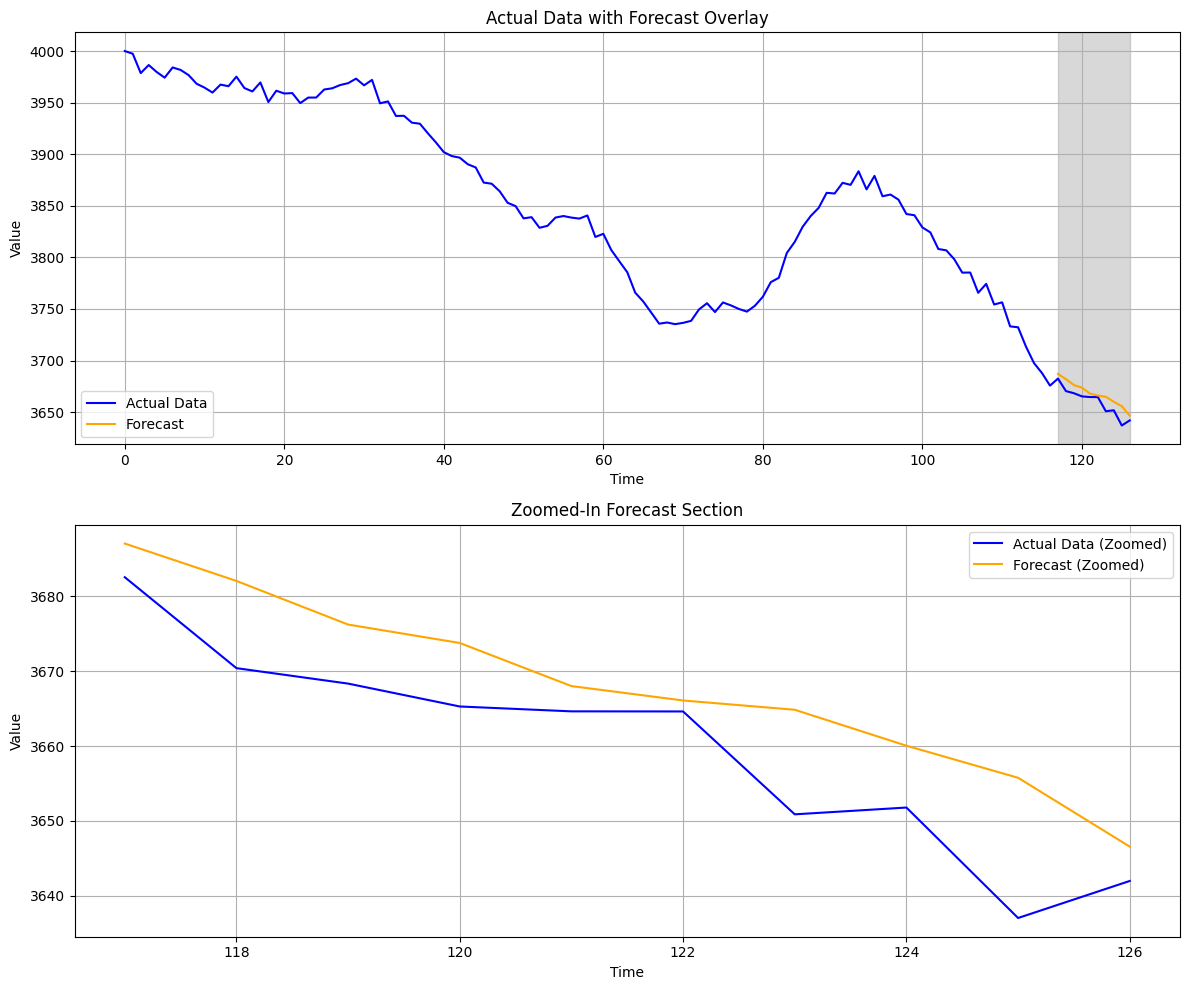

In [108]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

### Suavización exponencial

In [120]:
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

exponential_smoothing_test_errors, exponential_smoothing_forecasts = rolling_window_evaluation(
    model_class=ETSModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    error='mul',
    trend='mul',
    seasonal=None
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20921D+00    |proj g|=  1.73278D+01

At iterate    1    f=  5.20439D+00    |proj g|=  8.99872D-01

At iterate    2    f=  4.78530D+00    |proj g|=  8.97191D-01

At iterate    3    f=  3.66780D+00    |proj g|=  6.57386D+00

At iterate    4    f=  3.57131D+00    |proj g|=  4.76852D+00

At iterate    5    f=  3.53669D+00    |proj g|=  3.13914D+00

At iterate    6    f=  3.53568D+00    |proj g|=  2.47848D+00

At iterate    7    f=  3.53468D+00    |proj g|=  1.21423D+00

At iterate    8    f=  3.53360D+00    |proj g|=  6.35128D-01

At iterate    9    f=  3.53270D+00    |proj g|=  2.51856D+00

At iterate   10    f=  3.53204D+00    |proj g|=  3.58509D+00

At iterate   11    f=  3.53090D+00    |proj g|=  4.54131D+00

At iterate   12    f=  3.52413D+00    |proj g|=  8.86180D+00

At iterate   13    f=  3.5

In [121]:
exponential_smoothing_rmse = np.sqrt(np.mean(exponential_smoothing_test_errors))
print(f"Suavización exponencial RMSE: {exponential_smoothing_rmse}")

Suavización exponencial RMSE: 8.762822439978425


In [123]:
# plot_forecast(data['producto1'], exponential_smoothing_forecasts, train_size)